import os
import numpy as np
import pandas as pd

data_ = {}

for filename in os.listdir("data/Top100Cryptos/"):
    path = os.path.join("data/Top100Cryptos/", filename)
    try:
        name = filename.split(".")[0]
        data_[name] = pd.read_csv(path)
    except:
        pass

num_data = []
for name in data_.keys():
    num_data.append(data_[name].shape[0])
name_list = np.array(list(data_.keys()))[np.argsort(num_data)[::-1]]
big_names = name_list[:10]

data = dict()
for name in big_names:
    data[name] = data_[name]

In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np

# from .utils import convert_time
from rltensor.environments.core import Env


class TradeEnv(Env):
    """Environment only for close prices"""

    def __init__(self, data, start=None, end=None,
                 add_cash=True, keys=["close", "open", "high"]):
        self.keys = keys
        time_index = set()
        impute_data = {}
        data = deepcopy(data)
        for key, val in data.items():
            dates = val["date"].values
            # dates = [convert_time(d) for d in dates]
            impute_data[key] = dict(time_range=(dates[0], dates[-1]),
                                    impute_val=(val.iloc[0], val.iloc[-1]))
            data[key].index = dates
            time_index = time_index.union(set(dates))
        self.time_index = sorted(list(time_index))
        if add_cash:
            val = np.ones(len(self.time_index))
            cash_df = pd.DataFrame({"open": val,
                                    "high": val,
                                    "low": val,
                                    "close": val,
                                    "volume": val},
                                   index=self.time_index)
            key = "Cash"
            data[key] = cash_df
            impute_data[key] = dict(time_range=(self.time_index[0],
                                                self.time_index[-1]),
                                    impute_val=(cash_df.iloc[0],
                                                cash_df.iloc[-1]))
        self.impute_data = impute_data
        if start is None:
            self.start = self.time_index[0]
        else:
            self.start = min(start, self.time_index[0])
        if end is None:
            self.end = self.time_index[-1]
        else:
            self.end = max(end, self.time_index[-1])
        self.data = data
        self.symbols = list(data.keys())
        self.num_stocks = len(self.symbols)
        self.current_time = self.start
        self.current_step = 0
        # Use for calculate return
        self.prev_bars = self._get_bar()
        self.max_time = max(self.time_index)

    def _reset(self):
        self.current_time = self.start
        self.current_step = 0
        self.prev_bars = self._get_bar()
        observation = self._get_observation(self.prev_bars)
        return observation

    def _step(self, action, is_training=True, *args, **kwargs):
        current_bars = self._get_bar()
        returns = []
        for symbol in self.symbols:
            returns.append(current_bars[symbol]["close"] / self.prev_bars[symbol]["close"] - 1)
        returns = np.array(returns)
        # Update bars
        self.prev_bars = deepcopy(current_bars)
        self._update_time()
        observation = self._get_observation(current_bars)
        terminal = self._get_terminal()
        reward = np.sum(returns * action)
        info = {}
        info["returns"] = returns
        # print("reward action", reward, action)
        return observation, reward, terminal, info

    def _get_observation(self, bars):
        observation = []
        for symbol in self.symbols:
            observation.append([bars[symbol][key] for key in self.keys])
        return np.array(observation)

    def _update_time(self):
        index = self.time_index.index(self.current_time)
        self.current_time = self.time_index[index + 1]
        self.current_step += 1

    def _get_terminal(self):
        return self.current_time >= self.max_time

    def _get_bar(self):
        bar = {}
        for symbol in self.symbols:
            min_t = self.impute_data[symbol]["time_range"][0]
            max_t = self.impute_data[symbol]["time_range"][1]
            # print("current_time", self.current_time, "min_t", min_t, "max_t", max_t)
            if (min_t <= self.current_time) and (max_t >= self.current_time):
                if self.current_time in self.data[symbol].index:
                    bar[symbol] = self.data[symbol].loc[self.current_time]
                else:
                    bar[symbol] = deepcopy(self.impute_bar[symbol])
            elif min_t > self.current_time:
                bar[symbol] = self.impute_data[symbol]["impute_val"][0]
            else:
                bar[symbol] = self.impute_data[symbol]["impute_val"][1]
        # Keep value for imputation
        self.impute_bar = deepcopy(bar)
        return bar

    @property
    def action_dim(self):
        return self.num_stocks


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/home/tomoaki/work/shared_crypto/data/2017_export_30min.csv")
symbols = np.unique(df["currency_pair"].values)
data = {}
for symbol in symbols:
    data[symbol] = df.loc[df["currency_pair"]==symbol]

In [3]:
env.time_index[0]

NameError: name 'env' is not defined

In [4]:
# from rltensor.environments import TradeEnv
from rltensor.configs import eiie_config
from rltensor.agents import EIIE
import tensorflow as tf

env = TradeEnv(data)

conf = dict(
    action_spec={"type": "float", "shape": env.action_dim},
    state_spec={"type": "float", "shape": (env.action_dim, 3)}
)

default_config = eiie_config()
conf.update(default_config)

fit_config = dict(
        t_max= 100000000,
        num_max_start_steps=0,
        log_freq=1)
# _fit_config["log_freq"] = 10
# conf["t_learn_start"] = 100
lr_spec={"lr_init": 2.5e-3, "lr_decay_step": 1000,
                 "lr_decay": 0.96, "lr_min": 2.5e-3}
conf["lr_spec"] = lr_spec
    
tf.reset_default_graph()
eiie = EIIE(env=env, **conf)
eiie.fit(**fit_config)

/home/tomoaki/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Building tensorflow graph...


  0%|          | 0/100000000 [00:00<?, ?it/s]

Finished building tensorflow graph, spent time: 0.3330209255218506
Model saved in file: params/model.ckpt


  0%|          | 99992/100000000 [14:33<229:15:45, 121.04it/s]

KeyError: 'idx=-49'

  0%|          | 99992/100000000 [14:50<247:10:03, 112.27it/s]

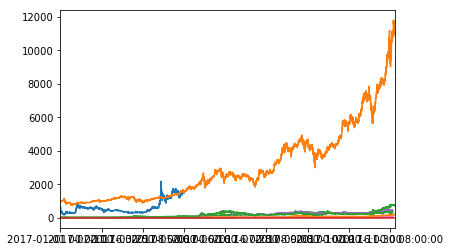

In [29]:
%matplotlib inline

for name in env.data.keys():
    env.data[name]["close"].plot()

In [33]:
test = Test()
x = test[::-1]

In [4]:
env.time_index[-1]

'2017-09-22'

In [9]:
env.time_index[0] > max(env.time_index)

False

In [4]:
1e6

1000000.0

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv("/home/tomoaki/work/shared_crypto/data/2017_export_30min.csv")

In [16]:
import numpy as np

symbols = np.unique(df["currency_pair"].values)
data = {}
for symbol in symbols:
    data[symbol] = df.loc[df["currency_pair"]==symbol]

In [17]:
data

{'USDT_BCH':                       date     open     high      low    close       volume  \
 16235  2017-08-02 08:30:00   550.00   550.00   301.01   380.00   102.336905   
 16236  2017-08-02 09:00:00   380.00   395.91   301.01   389.00  1026.470976   
 16237  2017-08-02 09:30:00   389.00   435.00   370.00   405.00  1163.104283   
 16238  2017-08-02 10:00:00   410.00   447.90   405.00   425.00   702.585828   
 16239  2017-08-02 10:30:00   425.00   510.00   424.98   498.00  1451.411992   
 16240  2017-08-02 11:00:00   497.00   508.76   441.00   450.00  1765.647268   
 16241  2017-08-02 11:30:00   447.01   500.00   447.00   495.00  1657.109085   
 16242  2017-08-02 12:00:00   495.00   575.00   494.99   567.10  2442.769341   
 16243  2017-08-02 12:30:00   569.00   672.00   523.00   668.89  4589.973996   
 16244  2017-08-02 13:00:00   668.89   693.70   601.00   645.00  2689.383063   
 16245  2017-08-02 13:30:00   641.02   650.00   427.01   485.01  4318.754034   
 16246  2017-08-02 14:00:00 

In [32]:
type(dict)

type

In [34]:
class ValidatePolygon(type):
    def __new__(meta, name, bases, class_dict):
        print('meta', meta)
        print('name', name)
        print('bases', bases)
        print('class_dict', class_dict)
        if bases != (object,):
            if class_dict['sides'] < 3:
                raise ValueError('Polygons need 3+ sides')
        return type.__new__(meta, name, bases, class_dict)

In [38]:
class Polygon(object, metaclass=ValidatePolygon):
    sides = None
    
    @classmethod
    def interior_angles(cls):
        return (cls.sides - 2) * 180

meta <class '__main__.ValidatePolygon'>
name Polygon
bases (<class 'object'>,)
class_dict {'__module__': '__main__', '__qualname__': 'Polygon', 'sides': None, 'interior_angles': <classmethod object at 0x7f861fd76358>}


In [41]:
class Triangle(Polygon):
    sides = 1

meta <class '__main__.ValidatePolygon'>
name Triangle
bases (<class '__main__.Polygon'>,)
class_dict {'__module__': '__main__', '__qualname__': 'Triangle', 'sides': 1}


ValueError: Polygons need 3+ sides

In [42]:
import json


class BetterSerializable(object):
    def __init__(self, *args):
        self.args = args
        
    def serializable(self):
        return json.dumps({
            'class': self.__class__.__name__,
            'args': self.args
        })

In [44]:
registry = {}

def registry_class(target_class):
    registry[target_class.__name__] = target_class
    
def deserialize(data):
    params = json.loads(data)
    name = params['class']
    target_class = registry[name]
    return target_class(*params['args'])

In [47]:
class Meta(type):
    def __new__(meta, name, bases, class_dict):
        cls = type.__new__(meta, name, bases, class_dict)
        registry_class(cls)
        return cls

In [48]:
class RegisterSerializable(BetterSerializable, metaclass=Meta):
    pass

In [49]:
class Vector3D(RegisterSerializable):
    def __init__(self, x, y, z):
        super().__init__(x, y, z)
        self.x,  self.y, self.z = x, y, z

In [50]:
v3 = Vector3D(10, 3, -7)

In [51]:
v3

In [52]:
registry

{'RegisterSerializable': __main__.RegisterSerializable,
 'Vector3D': __main__.Vector3D}

In [53]:
data = v3.serializable()

In [55]:
data

'{"class": "Vector3D", "args": [10, 3, -7]}'

In [57]:
x = deserialize(data)

In [58]:
x.__dict__

{'args': (10, 3, -7), 'x': 10, 'y': 3, 'z': -7}